In [18]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
#import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.model_selection import train_test_split
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# import xgboost as xgb
import optuna
from optuna import Trial, visualization



In [19]:

def save_feather(data_frame,folder,name):
    data_frame = pd.DataFrame(data_frame)
    data_frame.columns = data_frame.columns.astype(str)
    # data_frame.reset_index(drop=True)
    data_frame.reset_index().to_feather(folder+name+'.feather')


# load dataframe to feather
# path = ""
# load = feather.read_dataframe(path)


In [21]:
''' read data and insert into a combined dataframe'''

# data1 = pd.read_csv('sim_resultsNUC1.csv')
# data2 = pd.read_csv('sim_resultsNUC2.csv')
# data22 = pd.read_csv('sim_resultsNUC3.csv')

# data3 = pd.read_csv('sim_resultslinux1.csv')
# data4 = pd.read_csv('sim_resultslinux2.csv')
# data5 = pd.read_csv('sim_resultslinux3.csv')

# to_merge = [data1,data2,data22,data3,data4,data5]
# data = pd.concat(to_merge, ignore_index=True)
data = pd.read_csv('6dof_dataset.csv')
data = data.drop(columns=['Unnamed: 0'])
print("Dataframe Columns",data.columns)

data

Dataframe Columns Index(['Arm_ID', 'Point number', 'Move duration', 'Success',
       'Manipulability - mu', 'Mid joint proximity', 'Max Mid joint proximity',
       'Sum Mid joint proximity- all joints', 'Joint1 type', 'Joint1 axis',
       'Link1 length', 'Joint2 type', 'Joint2 axis', 'Link2 length',
       'Joint3 type', 'Joint3 axis', 'Link3 length', 'Joint4 type',
       'Joint4 axis', 'Link4 length', 'Joint5 type', 'Joint5 axis',
       'Link5 length', 'Joint6 type', 'Joint6 axis', 'Link6 length'],
      dtype='object')


,Arm_ID,Point number,Move duration,Success,Manipulability - mu,Mid joint proximity,Max Mid joint proximity,Sum Mid joint proximity- all joints,Joint1 type,Joint1 axis,...,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length
0,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,1,1.03569,False,NaN,NaN,NaN,NaN,roll,z,...,0.10000,pris,y,0.70000,pitch,y,0.10000,pitch,x,0.70000
1,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,2,1.02197,False,NaN,NaN,NaN,NaN,roll,z,...,0.10000,pris,y,0.70000,pitch,y,0.10000,pitch,x,0.70000
2,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,3,1.01439,False,NaN,NaN,NaN,NaN,roll,z,...,0.10000,pris,y,0.70000,pitch,y,0.10000,pitch,x,0.70000
3,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,4,1.03159,False,NaN,NaN,NaN,NaN,roll,z,...,0.10000,pris,y,0.70000,pitch,y,0.10000,pitch,x,0.70000
4,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,5,1.02709,False,NaN,NaN,NaN,NaN,roll,z,...,0.10000,pris,y,0.70000,pitch,y,0.10000,pitch,x,0.70000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025395,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,6,2.52078,True,0.06700,[0.019 0.068 0.024 0.037 0.105 0. 0.001],0.10500,0.25400,roll,z,...,0.50000,pris,y,0.10000,roll,x,0.10000,pitch,y,0.30000
1025396,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,7,2.62973,True,0.17100,[0.023 0.077 0.049 0.087 0.045 0. 0.002],0.08700,0.28300,roll,z,...,0.50000,pris,y,0.10000,roll,x,0.10000,pitch,y,0.30000
1025397,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,8,2.42348,True,0.49100,[0.121 0.083 0.074 0.124 0.045 0. 0.009],0.12400,0.45600,roll,z,...,0.50000,pris,y,0.10000,roll,x,0.10000,pitch,y,0.30000
1025398,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,9,1.42003,True,0.54300,[0.096 0.078 0.075 0.125 0.048 0. 0.009],0.12500,0.43100,roll,z,...,0.50000,pris,y,0.10000,roll,x,0.10000,pitch,y,0.30000


In [22]:
data.shape

(1025400, 26)

In [23]:
'''Data Understanding'''

''' OPTION 1 - PREDICT MEASUREMENTS BY ARM'S CONFIGURATION '''
''' Merge the data of the 10 points of each robotic arm to 1 sample'''
grouped_data = data.groupby(['Arm_ID']).agg(Success_Rates=pd.NamedAgg(column="Success", aggfunc='mean'),
    Min_Manipulability=pd.NamedAgg(column='Manipulability - mu', aggfunc='min'),
    Max_Manipulability=pd.NamedAgg(column='Manipulability - mu', aggfunc='max'),
    Manipulability_Rates=pd.NamedAgg(column='Manipulability - mu', aggfunc='mean'),
    MaxSum_Mid_joint_proximity=pd.NamedAgg(column='Sum Mid joint proximity- all joints', aggfunc='max')).reset_index()

no_sucsses = grouped_data.loc[grouped_data['Success_Rates']==0]
yes_sucsses = grouped_data.loc[grouped_data['Success_Rates']>0]
yes_sucsses

,Arm_ID,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity
10,_roll_z_0_1_pitch_y_0_1_pitch_x_0_1_pitch_x_0_...,0.10000,0.01400,0.01400,0.01400,0.21700
15,_roll_z_0_1_pitch_y_0_1_pitch_x_0_1_pitch_x_0_...,0.10000,0.00100,0.00100,0.00100,0.44100
23,_roll_z_0_1_pitch_y_0_1_pitch_x_0_1_pitch_x_0_...,0.20000,0.00600,0.01500,0.01050,0.27400
34,_roll_z_0_1_pitch_y_0_1_pitch_x_0_1_pitch_x_0_...,0.30000,0.36700,0.70600,0.54967,0.36900
47,_roll_z_0_1_pitch_y_0_1_pitch_x_0_1_pitch_x_0_...,0.10000,0.11900,0.11900,0.11900,0.21600
...,...,...,...,...,...,...
102534,_roll_z_0_1_roll_y_0_7_roll_y_0_7_pris_y_0_1_r...,1.00000,0.26300,1.53300,0.57650,3.46200
102535,_roll_z_0_1_roll_y_0_7_roll_y_0_7_pris_y_0_3_p...,0.20000,2.12900,2.26500,2.19700,0.35400
102536,_roll_z_0_1_roll_y_0_7_roll_y_0_7_pris_z_0_1_p...,0.70000,0.10500,0.42900,0.21257,3.31000
102538,_roll_z_0_1_roll_y_0_7_roll_y_0_7_roll_y_0_1_p...,1.00000,0.12100,0.90700,0.39740,0.44900


In [24]:
N_sucsses =no_sucsses.sample(29381)
grouped_data = pd.concat([yes_sucsses,N_sucsses]).reset_index(drop=True)
grouped_data_shuffled = grouped_data.sample(frac=1).reset_index(drop=True)
grouped_data_shuffled

,Arm_ID,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity
0,_roll_z_0_1_pris_z_0_7_roll_y_0_3_pris_y_0_3_p...,0.10000,0.00000,0.00000,0.00000,0.36400
1,_roll_z_0_1_roll_y_0_5_pris_z_0_5_pris_y_0_5_p...,0.00000,NaN,NaN,NaN,NaN
2,_roll_z_0_1_roll_y_0_1_pitch_y_0_5_pitch_x_0_1...,0.00000,NaN,NaN,NaN,NaN
3,_roll_z_0_1_pris_y_0_3_pris_x_0_5_roll_z_0_5_p...,0.00000,NaN,NaN,NaN,NaN
4,_roll_z_0_1_pris_y_0_1_roll_z_0_7_pitch_y_0_7_...,0.00000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
58757,_roll_z_0_1_pris_y_0_3_roll_x_0_5_pitch_y_0_5_...,1.00000,1.44000,1.49800,1.46060,0.24900
58758,_roll_z_0_1_pitch_y_0_5_pitch_z_0_5_pris_z_0_5...,0.00000,NaN,NaN,NaN,NaN
58759,_roll_z_0_1_pitch_y_0_1_roll_x_0_7_pris_z_0_3_...,1.00000,1.06000,2.00800,1.47400,0.22200
58760,_roll_z_0_1_pris_y_0_1_pris_y_0_1_pitch_y_0_5_...,0.00000,NaN,NaN,NaN,NaN


In [25]:
''' count NULL values by column'''
print("NULL values by column\n",grouped_data_shuffled.isnull().sum(axis = 0))


''' Analyze Success Rates'''
max_success = grouped_data_shuffled["Success_Rates"].max()
min_success = grouped_data_shuffled["Success_Rates"].min()

print("\nMax success", max_success)
print("Min success", min_success)

''' Analyze Manipulability Rates'''
max_mani_rate = grouped_data_shuffled["Manipulability_Rates"].max()
min_mani_rate = grouped_data_shuffled["Manipulability_Rates"].min()

print("\nMax Manipulability_Rates", max_mani_rate)
print("Min Manipulability_Rates", min_mani_rate)


NULL values by column
 Arm_ID                            0
Success_Rates                     0
Min_Manipulability            29381
Max_Manipulability            29381
Manipulability_Rates          29381
MaxSum_Mid_joint_proximity    29381
dtype: int64

Max success 1.0
Min success 0.0

Max Manipulability_Rates 3.3787
Min Manipulability_Rates 0.0


In [26]:
'''Check for duplicate arms '''
df_duplicates = grouped_data_shuffled.duplicated(subset = ['Arm_ID'])
df_duplicates.value_counts()

False    58762
dtype: int64

In [27]:
''' split arm name to features '''
# new data frame with split value columns
new = grouped_data_shuffled["Arm_ID"].str.split("_", expand=True)

grouped_data_shuffled["Joint1 type"] = new[1]
grouped_data_shuffled["Joint1 axis"] = new[2]
grouped_data_shuffled["Link1 length"] = new[3]+"."+new[4]

grouped_data_shuffled["Joint2 type"] = new[5]
grouped_data_shuffled["Joint2 axis"] = new[6]
grouped_data_shuffled["Link2 length"] = new[7]+"."+new[8]

grouped_data_shuffled["Joint3 type"] = new[9]
grouped_data_shuffled["Joint3 axis"] = new[10]
grouped_data_shuffled["Link3 length"] = new[11]+"."+new[12]

grouped_data_shuffled["Joint4 type"] = new[13]
grouped_data_shuffled["Joint4 axis"] = new[14]
grouped_data_shuffled["Link4 length"] = new[15]+"."+new[16]

grouped_data_shuffled["Joint5 type"] = new[17]
grouped_data_shuffled["Joint5 axis"] = new[18]
grouped_data_shuffled["Link5 length"] = new[19]+"."+new[20]

grouped_data_shuffled["Joint6 type"] = new[21]
grouped_data_shuffled["Joint6 axis"] = new[22]
grouped_data_shuffled["Link6 length"] = new[23]+"."+new[24]

grouped_data_shuffled = grouped_data_shuffled.drop(['Arm_ID'], axis=1)


grouped_data_shuffled

,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity,Joint1 type,Joint1 axis,Link1 length,Joint2 type,Joint2 axis,...,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length
0,0.10000,0.00000,0.00000,0.00000,0.36400,roll,z,0.1,pris,z,...,0.3,pris,y,0.3,pitch,y,0.1,pitch,y,0.3
1,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,roll,y,...,0.5,pris,y,0.5,pitch,z,0.1,pitch,z,0.1
2,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,roll,y,...,0.5,pitch,x,0.1,pitch,z,0.3,pitch,z,0.3
3,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,pris,y,...,0.5,roll,z,0.5,pris,y,0.3,roll,y,0.1
4,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,pris,y,...,0.7,pitch,y,0.7,pitch,x,0.3,pitch,x,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58757,1.00000,1.44000,1.49800,1.46060,0.24900,roll,z,0.1,pris,y,...,0.5,pitch,y,0.5,pitch,y,0.1,pris,x,0.1
58758,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.5,pris,z,0.5,pitch,z,0.3,roll,z,0.1
58759,1.00000,1.06000,2.00800,1.47400,0.22200,roll,z,0.1,pitch,y,...,0.7,pris,z,0.3,pitch,y,0.1,roll,z,0.7
58760,0.00000,NaN,NaN,NaN,NaN,roll,z,0.1,pris,y,...,0.1,pitch,y,0.5,pitch,z,0.5,pitch,z,0.7


In [28]:
'''Change coliumns order'''
grouped_data_shuffled = grouped_data_shuffled[['Joint1 type', 'Joint1 axis', 'Link1 length', 'Joint2 type', 'Joint2 axis',
       'Link2 length', 'Joint3 type', 'Joint3 axis', 'Link3 length',
       'Joint4 type', 'Joint4 axis', 'Link4 length', 'Joint5 type',
       'Joint5 axis', 'Link5 length', 'Joint6 type', 'Joint6 axis',
       'Link6 length','Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates','MaxSum_Mid_joint_proximity']]

grouped_data_shuffled


,Joint1 type,Joint1 axis,Link1 length,Joint2 type,Joint2 axis,Link2 length,Joint3 type,Joint3 axis,Link3 length,Joint4 type,...,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity
0,roll,z,0.1,pris,z,0.7,roll,y,0.3,pris,...,y,0.1,pitch,y,0.3,0.10000,0.00000,0.00000,0.00000,0.36400
1,roll,z,0.1,roll,y,0.5,pris,z,0.5,pris,...,z,0.1,pitch,z,0.1,0.00000,NaN,NaN,NaN,NaN
2,roll,z,0.1,roll,y,0.1,pitch,y,0.5,pitch,...,z,0.3,pitch,z,0.3,0.00000,NaN,NaN,NaN,NaN
3,roll,z,0.1,pris,y,0.3,pris,x,0.5,roll,...,y,0.3,roll,y,0.1,0.00000,NaN,NaN,NaN,NaN
4,roll,z,0.1,pris,y,0.1,roll,z,0.7,pitch,...,x,0.3,pitch,x,0.1,0.00000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58757,roll,z,0.1,pris,y,0.3,roll,x,0.5,pitch,...,y,0.1,pris,x,0.1,1.00000,1.44000,1.49800,1.46060,0.24900
58758,roll,z,0.1,pitch,y,0.5,pitch,z,0.5,pris,...,z,0.3,roll,z,0.1,0.00000,NaN,NaN,NaN,NaN
58759,roll,z,0.1,pitch,y,0.1,roll,x,0.7,pris,...,y,0.1,roll,z,0.7,1.00000,1.06000,2.00800,1.47400,0.22200
58760,roll,z,0.1,pris,y,0.1,pris,y,0.1,pitch,...,z,0.5,pitch,z,0.7,0.00000,NaN,NaN,NaN,NaN


In [29]:
# grouped_data[['Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates']] = grouped_data[['Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates']].astype('float64')
# grouped_data[["Joint1 type","Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type"]] = grouped_data[["Joint1 type","Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type"]].astype("string")
# grouped_data[["Joint1 axis","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"]]= grouped_data[["Joint1 axis","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"]] .astype("string")
# grouped_data[["Link1 length","Link2 length","Link3 length","Link4 length","Link5 length","Link6 length"]] = grouped_data[["Link1 length","Link2 length","Link3 length","Link4 length","Link5 length","Link6 length"]] .astype('float64')


In [31]:
''' Data Pre-Processing/ Data Preparation '''
'''Drop Joint1 type,Joint1 axis,Link1 length'''
grouped_data_shuffled = grouped_data_shuffled.drop(columns=["Joint1 type","Joint1 axis",'Link1 length' ,'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates','MaxSum_Mid_joint_proximity'])

grouped_data_shuffled


,Joint2 type,Joint2 axis,Link2 length,Joint3 type,Joint3 axis,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length,Success_Rates
0,pris,z,0.7,roll,y,0.3,pris,y,0.3,pitch,y,0.1,pitch,y,0.3,0.10000
1,roll,y,0.5,pris,z,0.5,pris,y,0.5,pitch,z,0.1,pitch,z,0.1,0.00000
2,roll,y,0.1,pitch,y,0.5,pitch,x,0.1,pitch,z,0.3,pitch,z,0.3,0.00000
3,pris,y,0.3,pris,x,0.5,roll,z,0.5,pris,y,0.3,roll,y,0.1,0.00000
4,pris,y,0.1,roll,z,0.7,pitch,y,0.7,pitch,x,0.3,pitch,x,0.1,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58757,pris,y,0.3,roll,x,0.5,pitch,y,0.5,pitch,y,0.1,pris,x,0.1,1.00000
58758,pitch,y,0.5,pitch,z,0.5,pris,z,0.5,pitch,z,0.3,roll,z,0.1,0.00000
58759,pitch,y,0.1,roll,x,0.7,pris,z,0.3,pitch,y,0.1,roll,z,0.7,1.00000
58760,pris,y,0.1,pris,y,0.1,pitch,y,0.5,pitch,z,0.5,pitch,z,0.7,0.00000


In [32]:
'''Get Dummies'''
grouped_data_shuffled = pd.get_dummies(grouped_data_shuffled, columns = ["Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"])

grouped_data_shuffled


,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.7,0.3,0.3,0.1,0.3,0.10000,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0.5,0.5,0.5,0.1,0.1,0.00000,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
2,0.1,0.5,0.1,0.3,0.3,0.00000,0,0,1,1,...,0,1,0,0,0,0,1,0,0,1
3,0.3,0.5,0.5,0.3,0.1,0.00000,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
4,0.1,0.7,0.7,0.3,0.1,0.00000,0,1,0,0,...,1,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58757,0.3,0.5,0.5,0.1,0.1,1.00000,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
58758,0.5,0.5,0.5,0.3,0.1,0.00000,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
58759,0.1,0.7,0.3,0.1,0.7,1.00000,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
58760,0.1,0.1,0.5,0.5,0.7,0.00000,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [33]:
# train_df = grouped_data_shuffled.sample(frac=0.8,random_state=200) #random state is a seed value
# test_df = grouped_data_shuffled.drop(train_df.index)
# X = train_df.loc[:,train_df.columns != 'Success_Rates']
# Y = train_df.loc[:,train_df.columns == 'Success_Rates']
# X= X.to_numpy()
# Y = Y.to_numpy()
# X = [[float(j) for j in i] for i in X]
# X=np.array(X)

# x_test = test_df.loc[:,test_df.columns != 'Success_Rates']
# y_test = test_df.loc[:,test_df.columns == 'Success_Rates']
# x_test= x_test.to_numpy()
# y_test = y_test.to_numpy()
# x_test = [[float(j) for j in i] for i in x_test]
# x_test= np.array(x_test)
X = grouped_data_shuffled.loc[:,grouped_data_shuffled.columns != 'Success_Rates']
Y = grouped_data_shuffled.loc[:,grouped_data_shuffled.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)



x train
 (35256, 34)
y train
 (35256, 1)
x valid
 (11753, 34)
y valid
 (11753, 1)
x test
 (11753, 34)
y test
 (11753, 1)


In [34]:
# define the model
clf1= TabNetRegressor()


Device used : cpu


In [35]:
# fit the model
clf1.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','mse'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.1307  | train_mae: 0.24434 | train_mse: 0.10297 | valid_mae: 0.24615 | valid_mse: 0.10502 |  0:00:02s
epoch 1  | loss: 0.10217 | train_mae: 0.23919 | train_mse: 0.09982 | valid_mae: 0.24086 | valid_mse: 0.10146 |  0:00:05s
epoch 2  | loss: 0.09628 | train_mae: 0.24394 | train_mse: 0.09323 | valid_mae: 0.24657 | valid_mse: 0.09531 |  0:00:08s
epoch 3  | loss: 0.0902  | train_mae: 0.22744 | train_mse: 0.08466 | valid_mae: 0.23178 | valid_mse: 0.08812 |  0:00:10s
epoch 4  | loss: 0.08287 | train_mae: 0.20037 | train_mse: 0.07807 | valid_mae: 0.20539 | valid_mse: 0.08215 |  0:00:13s
epoch 5  | loss: 0.07717 | train_mae: 0.20676 | train_mse: 0.07294 | valid_mae: 0.21222 | valid_mse: 0.07704 |  0:00:15s
epoch 6  | loss: 0.07407 | train_mae: 0.19727 | train_mse: 0.06943 | valid_mae: 0.20196 | valid_mse: 0.07292 |  0:00:18s
epoch 7  | loss: 0.0722  | train_mae: 0.21135 | train_mse: 0.07899 | valid_mae: 0.21755 | valid_mse: 0.08426 |  0:00:21s
epoch 8  | loss: 0.07078 | train

epoch 68 | loss: 0.04861 | train_mae: 0.15664 | train_mse: 0.05027 | valid_mae: 0.16847 | valid_mse: 0.05878 |  0:03:06s
epoch 69 | loss: 0.04893 | train_mae: 0.14687 | train_mse: 0.04336 | valid_mae: 0.16088 | valid_mse: 0.05286 |  0:03:08s
epoch 70 | loss: 0.04786 | train_mae: 0.14124 | train_mse: 0.04255 | valid_mae: 0.1547  | valid_mse: 0.0519  |  0:03:11s
epoch 71 | loss: 0.04765 | train_mae: 0.14613 | train_mse: 0.04239 | valid_mae: 0.16105 | valid_mse: 0.05232 |  0:03:14s
epoch 72 | loss: 0.04687 | train_mae: 0.14108 | train_mse: 0.04192 | valid_mae: 0.15573 | valid_mse: 0.05214 |  0:03:17s
epoch 73 | loss: 0.04687 | train_mae: 0.14939 | train_mse: 0.04224 | valid_mae: 0.1635  | valid_mse: 0.05185 |  0:03:19s
epoch 74 | loss: 0.04732 | train_mae: 0.14297 | train_mse: 0.04207 | valid_mae: 0.15604 | valid_mse: 0.05102 |  0:03:22s
epoch 75 | loss: 0.04639 | train_mae: 0.14141 | train_mse: 0.0422  | valid_mae: 0.15539 | valid_mse: 0.05216 |  0:03:25s
epoch 76 | loss: 0.04697 | train

epoch 136| loss: 0.04367 | train_mae: 0.13626 | train_mse: 0.03891 | valid_mae: 0.15257 | valid_mse: 0.05045 |  0:06:15s
epoch 137| loss: 0.04402 | train_mae: 0.13673 | train_mse: 0.03807 | valid_mae: 0.1523  | valid_mse: 0.04903 |  0:06:17s
epoch 138| loss: 0.04351 | train_mae: 0.13714 | train_mse: 0.0388  | valid_mae: 0.15348 | valid_mse: 0.05013 |  0:06:20s
epoch 139| loss: 0.0433  | train_mae: 0.13162 | train_mse: 0.03756 | valid_mae: 0.14843 | valid_mse: 0.04947 |  0:06:23s
epoch 140| loss: 0.04307 | train_mae: 0.13256 | train_mse: 0.03734 | valid_mae: 0.14919 | valid_mse: 0.04895 |  0:06:26s
epoch 141| loss: 0.04287 | train_mae: 0.13281 | train_mse: 0.037   | valid_mae: 0.15022 | valid_mse: 0.0491  |  0:06:28s
epoch 142| loss: 0.04353 | train_mae: 0.135   | train_mse: 0.03843 | valid_mae: 0.15072 | valid_mse: 0.0496  |  0:06:31s
epoch 143| loss: 0.04293 | train_mae: 0.13334 | train_mse: 0.0371  | valid_mae: 0.15029 | valid_mse: 0.04889 |  0:06:34s
epoch 144| loss: 0.04271 | train

epoch 204| loss: 0.04186 | train_mae: 0.13487 | train_mse: 0.03629 | valid_mae: 0.15545 | valid_mse: 0.05031 |  0:09:22s
epoch 205| loss: 0.04168 | train_mae: 0.13029 | train_mse: 0.03585 | valid_mae: 0.14923 | valid_mse: 0.04891 |  0:09:25s
epoch 206| loss: 0.0419  | train_mae: 0.13086 | train_mse: 0.03609 | valid_mae: 0.15068 | valid_mse: 0.04961 |  0:09:28s
epoch 207| loss: 0.04118 | train_mae: 0.12881 | train_mse: 0.03646 | valid_mae: 0.14939 | valid_mse: 0.05084 |  0:09:31s
epoch 208| loss: 0.04171 | train_mae: 0.13178 | train_mse: 0.0372  | valid_mae: 0.15082 | valid_mse: 0.04994 |  0:09:34s
epoch 209| loss: 0.04195 | train_mae: 0.12996 | train_mse: 0.03543 | valid_mae: 0.15055 | valid_mse: 0.04963 |  0:09:36s
epoch 210| loss: 0.04141 | train_mae: 0.13259 | train_mse: 0.03635 | valid_mae: 0.15237 | valid_mse: 0.04958 |  0:09:39s
epoch 211| loss: 0.04117 | train_mae: 0.13054 | train_mse: 0.03554 | valid_mae: 0.15086 | valid_mse: 0.04966 |  0:09:42s
epoch 212| loss: 0.04127 | train

In [36]:
preds = clf1.predict(x_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
test_mae = mean_absolute_error(y_test, preds)
test_rmse = np.sqrt(test_mse)

print(f"BEST VALID SCORE: {clf1.best_cost}")
print(f"MSE TEST SCORE: {test_mse}")
print(f"RMSE TEST SCORE: {test_rmse}")
print(f"MAE TEST SCORE: {test_mae}")

from sklearn.metrics import r2_score
score = r2_score(y_test, preds)
print(score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

BEST VALID SCORE: 0.04867675534310392
MSE TEST SCORE: 0.04990282884962807
RMSE TEST SCORE: 0.22338941078222144
MAE TEST SCORE: 0.15282798302414355
0.546635079051802
The accuracy of our model is 55.00000000000001%


In [37]:
preds
y_test

array([[0. ],
       [1. ],
       [0.7],
       ...,
       [0. ],
       [1. ],
       [0.9]])

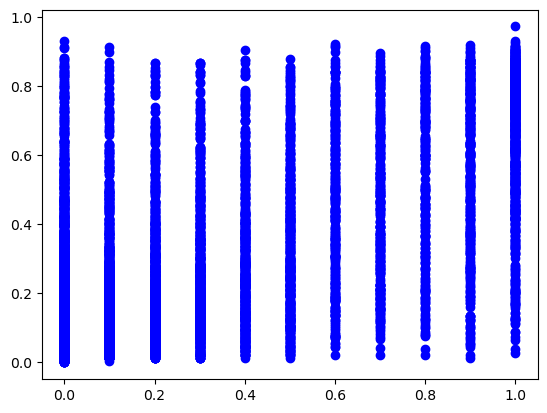

In [38]:
plt.scatter(y_test,preds, c ="blue")

# To show the plot
plt.show()

In [39]:
clf1.feature_importances_
with np.printoptions(precision=2, suppress=True):
    print(clf1.feature_importances_)
len(clf1.feature_importances_)


[0.2  0.   0.   0.   0.   0.   0.12 0.   0.   0.03 0.01 0.   0.   0.
 0.02 0.   0.   0.04 0.12 0.   0.27 0.   0.   0.03 0.   0.   0.   0.
 0.   0.   0.   0.08 0.   0.08]


34

In [40]:
feat_importances = pd.Series(clf1.feature_importances_ ,index = train_df.drop(columns='Success_Rates').columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importances")
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\feat_importances.png', bbox_inches='tight')

NameError: name 'train_df' is not defined

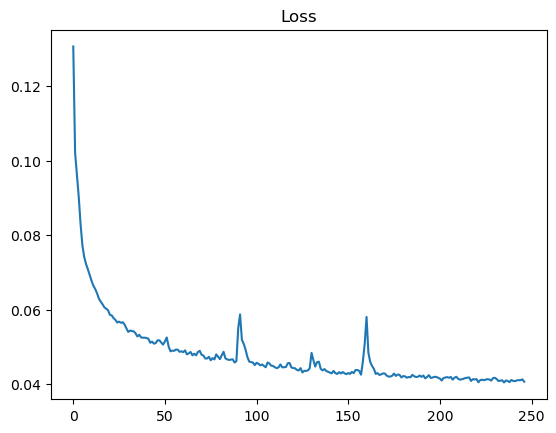

In [41]:
plt.plot(clf1.history['loss'])
plt.title("Loss")
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\loss_tabnet1.png', bbox_inches='tight')

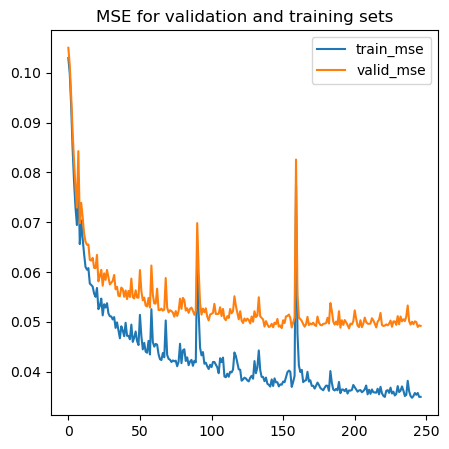

In [42]:
plt.plot(clf1.history['train_mse'], label= 'train_mse')
plt.plot(clf1.history['valid_mse'], label ='valid_mse')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MSE for validation and training sets")
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\mse_tabnet1.png', bbox_inches='tight')


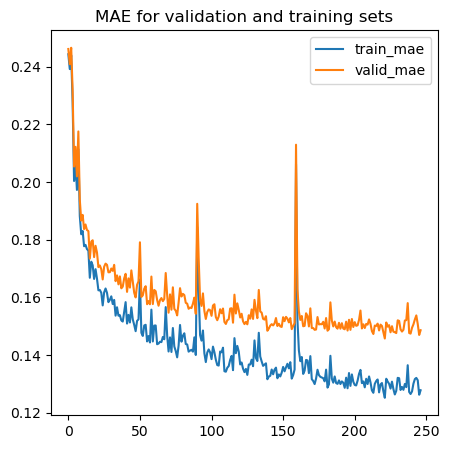

In [43]:
plt.plot(clf1.history['train_mae'], label= 'train_mae')
plt.plot(clf1.history['valid_mae'], label ='valid_mae')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MAE for validation and training sets")
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\mae_tabnet1.png', bbox_inches='tight')

In [44]:
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
        regressor = TabNetRegressor(**tabnet_params)
        regressor.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                  eval_metric=['mse','mae'])
        CV_score_array.append(regressor.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [45]:
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60) #5 hours

[I 2022-12-19 17:34:06,858] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 38 with best_epoch = 36 and best_val_0_mae = 0.12067
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 38 with best_epoch = 35 and best_val_0_mae = 0.13007
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 38 with best_epoch = 37 and best_val_0_mae = 0.13454
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 38 with best_epoch = 33 and best_val_0_mae = 0.12936
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 38 with best_epoch = 36 and best_val_0_mae = 0.12247
Best weights from best epoch are automatically used!


[I 2022-12-19 17:38:20,881] Trial 0 finished with value: 0.1274237333073474 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 0.00048040438482194984, 'patienceScheduler': 4, 'patience': 30, 'epochs': 38}. Best is trial 0 with value: 0.1274237333073474.


Stop training because you reached max_epochs = 56 with best_epoch = 52 and best_val_0_mae = 0.13158
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 56 with best_epoch = 54 and best_val_0_mae = 0.12524
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 56 with best_epoch = 54 and best_val_0_mae = 0.13612
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 56 with best_epoch = 53 and best_val_0_mae = 0.12523
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 56 with best_epoch = 53 and best_val_0_mae = 0.12068
Best weights from best epoch are automatically used!


[I 2022-12-19 17:46:10,800] Trial 1 finished with value: 0.12776905557066037 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0007456438178891508, 'patienceScheduler': 5, 'patience': 22, 'epochs': 56}. Best is trial 0 with value: 0.1274237333073474.


In [46]:
#train a TabNet with the best params to make submission
TabNet_params = study.best_params

In [47]:
TabNet_params

{'mask_type': 'entmax',
 'n_da': 60,
 'n_steps': 1,
 'gamma': 1.0,
 'n_shared': 1,
 'lambda_sparse': 0.00048040438482194984,
 'patienceScheduler': 4,
 'patience': 30,
 'epochs': 38}

In [48]:
final_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )
epochs = TabNet_params['epochs']
final_params

{'n_d': 60,
 'n_a': 60,
 'n_steps': 1,
 'gamma': 1.0,
 'lambda_sparse': 0.00048040438482194984,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02, 'weight_decay': 1e-05},
 'mask_type': 'entmax',
 'n_shared': 1,
 'scheduler_params': {'mode': 'min',
  'patience': 4,
  'min_lr': 1e-05,
  'factor': 0.5},
 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'verbose': 0}

In [49]:
regressor = TabNetRegressor(**final_params)
regressor.fit(x_train,y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    patience=TabNet_params['patience'], max_epochs=epochs,
    eval_metric=['mse','mae'])

Stop training because you reached max_epochs = 38 with best_epoch = 34 and best_valid_mae = 0.13832
Best weights from best epoch are automatically used!


In [50]:
preds = regressor.predict(x_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
test_mae = mean_absolute_error(y_pred=preds, y_true=y_test)

print(f"BEST VALID SCORE: {regressor.best_cost}")
print(f"MSE TEST SCORE: {test_mse}")
print(f"MAE TEST SCORE: {test_mae}")

score = r2_score(y_test, preds)
print(score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

BEST VALID SCORE: 0.13831555761714365
MSE TEST SCORE: 0.044299283390206314
MAE TEST SCORE: 0.14021256055846973
0.5975430336267923
The accuracy of our model is 60.0%


In [53]:
preds

array([[0.4357776 ],
       [0.7956706 ],
       [0.52054185],
       ...,
       [0.01421937],
       [0.88821036],
       [0.4669851 ]], dtype=float32)

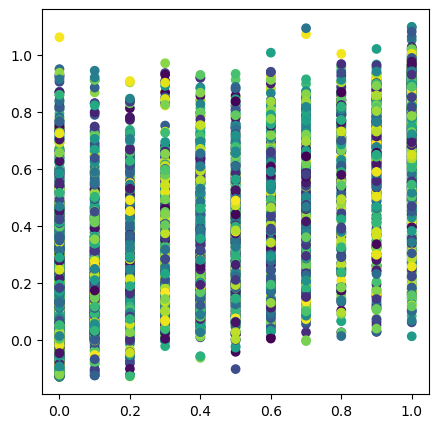

In [52]:
import numpy as np
import matplotlib.pyplot as plt
colors = np.random.rand(11753)
plt.scatter(y_test,preds, c =colors)

# To show the plot
plt.show()

In [312]:
'''TabNet plots after optimization'''
# features importance
feat_importances = pd.Series(regressor.feature_importances_ ,index = grouped_data_shuffled.loc[:,grouped_data_shuffled.columns != 'Success_Rates'].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importances")
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\feat_importances2.png', bbox_inches='tight')
plt.show()

#loss
plt.plot(regressor.history['loss'])
plt.title("Loss")
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\loss_tabnet2.png', bbox_inches='tight')
plt.show()

# mse
plt.plot(regressor.history['train_mse'], label= 'train_mse')
plt.plot(regressor.history['valid_mse'], label ='valid_mse')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MSE for validation and training sets")
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\mse_tabnet2.png', bbox_inches='tight')
plt.show()

# mae
plt.plot(regressor.history['train_mae'], label= 'train_mae')
plt.plot(regressor.history['valid_mae'], label ='valid_mae')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MAE for validation and training sets")
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\mae_tabnet2.png', bbox_inches='tight')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [605]:
# '''Save and load model'''
# save state dict
path = 'TabModel'
saved_filename = clf1.save_model(path)
# define new model and load save parameters
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filename)

Successfully saved model at TabModel.zip
Device used : cpu
Device used : cpu


In [616]:
np.array(train_df.drop(columns=['Manipulability_Rates','Success_Rates']).columns)

array(['Link2 length', 'Link3 length', 'Link4 length', 'Link5 length',
       'Link6 length', 'Joint2 type_pitch', 'Joint2 type_pris',
       'Joint2 type_roll', 'Joint3 type_pitch', 'Joint3 type_pris',
       'Joint3 type_roll', 'Joint4 type_pitch', 'Joint4 type_pris',
       'Joint4 type_roll', 'Joint5 type_pitch', 'Joint5 type_pris',
       'Joint5 type_roll', 'Joint6 type_pitch', 'Joint6 type_pris',
       'Joint6 type_roll', 'Joint2 axis_y', 'Joint2 axis_z',
       'Joint3 axis_x', 'Joint3 axis_y', 'Joint3 axis_z', 'Joint4 axis_x',
       'Joint4 axis_y', 'Joint4 axis_z', 'Joint5 axis_x', 'Joint5 axis_y',
       'Joint5 axis_z', 'Joint6 axis_x', 'Joint6 axis_y', 'Joint6 axis_z'],
      dtype=object)

First estimator
[0]	validation_0-logloss:0.51811	validation_1-logloss:0.51681
[1]	validation_0-logloss:0.42032	validation_1-logloss:0.41946
[2]	validation_0-logloss:0.36238	validation_1-logloss:0.36150
[3]	validation_0-logloss:0.32565	validation_1-logloss:0.32537
[4]	validation_0-logloss:0.30135	validation_1-logloss:0.30149
[5]	validation_0-logloss:0.28511	validation_1-logloss:0.28593
[6]	validation_0-logloss:0.27424	validation_1-logloss:0.27591
[7]	validation_0-logloss:0.26676	validation_1-logloss:0.26889
[8]	validation_0-logloss:0.26171	validation_1-logloss:0.26471
[9]	validation_0-logloss:0.25794	validation_1-logloss:0.26203
[10]	validation_0-logloss:0.25494	validation_1-logloss:0.26006
[11]	validation_0-logloss:0.25330	validation_1-logloss:0.25924
[12]	validation_0-logloss:0.25190	validation_1-logloss:0.25863
[13]	validation_0-logloss:0.25106	validation_1-logloss:0.25810
[14]	validation_0-logloss:0.25013	validation_1-logloss:0.25781
[15]	validation_0-logloss:0.24926	validation_1-lo

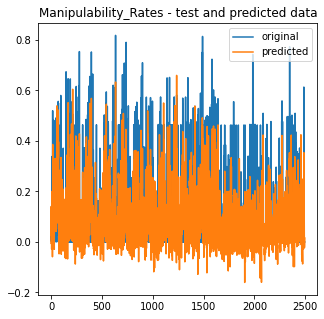

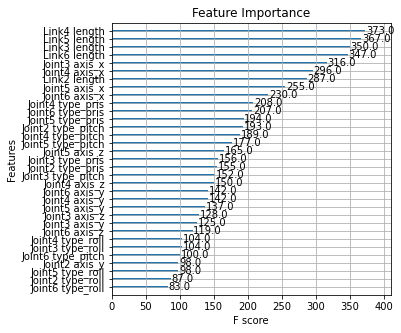

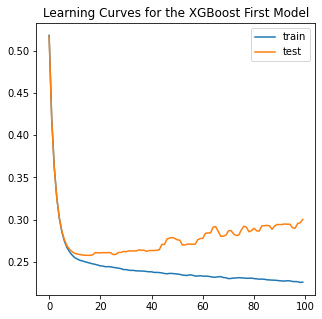

MSE first XGBOOST:  0.015460061501274176
MAE first XGBOOST:  0.08618701799919376

Second estimator
[0]	validation_0-logloss:0.67285	validation_1-logloss:0.67452
[1]	validation_0-logloss:0.66133	validation_1-logloss:0.66379
[2]	validation_0-logloss:0.65452	validation_1-logloss:0.65822
[3]	validation_0-logloss:0.64988	validation_1-logloss:0.65446
[4]	validation_0-logloss:0.64629	validation_1-logloss:0.65140
[5]	validation_0-logloss:0.64371	validation_1-logloss:0.64944
[6]	validation_0-logloss:0.64201	validation_1-logloss:0.64819
[7]	validation_0-logloss:0.64024	validation_1-logloss:0.64689
[8]	validation_0-logloss:0.63894	validation_1-logloss:0.64614
[9]	validation_0-logloss:0.63744	validation_1-logloss:0.64511
[10]	validation_0-logloss:0.63592	validation_1-logloss:0.64381
[11]	validation_0-logloss:0.63498	validation_1-logloss:0.64327
[12]	validation_0-logloss:0.63407	validation_1-logloss:0.64247
[13]	validation_0-logloss:0.63340	validation_1-logloss:0.64216
[14]	validation_0-logloss:0.6

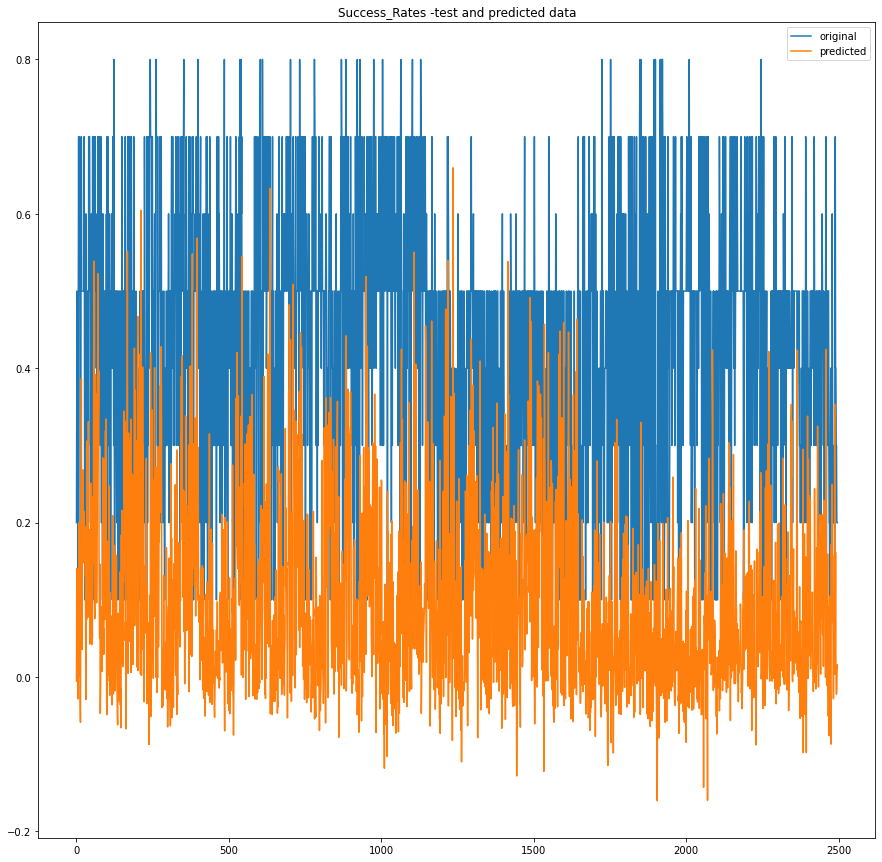

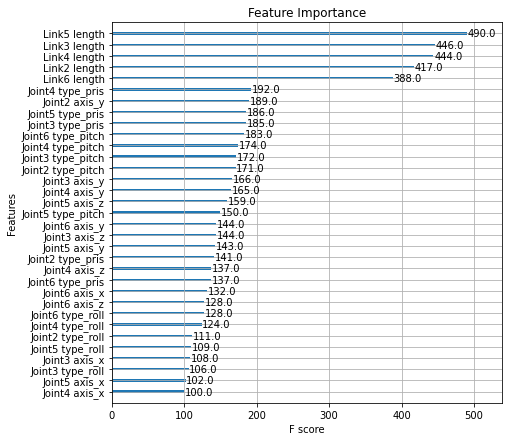

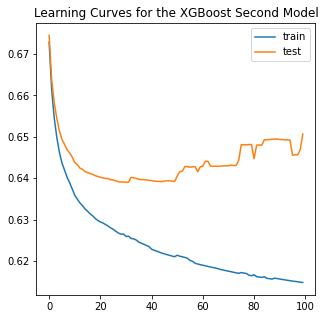

MSE second XGBOOST:  0.014523042965852231
MAE second XGBOOST:  0.08618701799919376


In [636]:
'''2 XGBOOST MODELS'''
from sklearn.metrics import mean_absolute_error
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

y1_train = train_df[['Manipulability_Rates']].values
y2_train = train_df[['Success_Rates']].values

y1_test = test_df[['Manipulability_Rates']].values
y2_test= test_df[['Success_Rates']].values

# First estimator
print("First estimator")
xgbr1 = xgb.XGBRegressor(verbosity=0) 

evalset = [(X, y1_train), (x_test,y1_test)]
xgbr1.fit(X, y1_train , eval_metric='logloss', eval_set=evalset)

# score1 = xgbr1.score(X, y1_train)  
# print("Training score: ", score1)
    
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr1, X, y1_train, cv=kfold ,scoring='neg_mean_absolute_error')
print("K-fold CV MSE: " ,kf_cv_scores.mean())

ypred = xgbr1.predict(x_test)
mse1 = mean_squared_error(y1_test, ypred)
mae1 = mean_absolute_error(y1_test, ypred)

# predictions
x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Manipulability_Rates - test and predicted data")
plt.rcParams['figure.figsize'] = [5, 5]
plt.legend()
plt.show()

# plot feature importance
xgbr1.get_booster().feature_names = ['Link2 length', 'Link3 length', 'Link4 length', 'Link5 length',
       'Link6 length', 'Joint2 type_pitch', 'Joint2 type_pris',
       'Joint2 type_roll', 'Joint3 type_pitch', 'Joint3 type_pris',
       'Joint3 type_roll', 'Joint4 type_pitch', 'Joint4 type_pris',
       'Joint4 type_roll', 'Joint5 type_pitch', 'Joint5 type_pris',
       'Joint5 type_roll', 'Joint6 type_pitch', 'Joint6 type_pris',
       'Joint6 type_roll', 'Joint2 axis_y', 'Joint2 axis_z',
       'Joint3 axis_x', 'Joint3 axis_y', 'Joint3 axis_z', 'Joint4 axis_x',
       'Joint4 axis_y', 'Joint4 axis_z', 'Joint5 axis_x', 'Joint5 axis_y',
       'Joint5 axis_z', 'Joint6 axis_x', 'Joint6 axis_y', 'Joint6 axis_z']
xgb.plot_importance(xgbr1.get_booster())
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importance")
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\feat_xg1.png', bbox_inches='tight')
plt.show()

# plot learning curves
results = xgbr1.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.rcParams['figure.figsize'] = [15, 15]
plt.title("Learning Curves for the XGBoost First Model")
# show the legend
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\learn_xg1.png', bbox_inches='tight')
# show the plot
plt.show()

print("MSE first XGBOOST: " , mse1)
print("MAE first XGBOOST: " , mae1)

# Second estimator
print()
print("Second estimator")
xgbr2 = xgb.XGBRegressor(verbosity=0) 

evalset = [(X, y2_train), (x_test,y2_test)]
xgbr2.fit(X, y2_train , eval_metric='logloss', eval_set=evalset)

score2 = xgbr2.score(X, y2_train)  
# print("Training score: ", score2)
    
kfold2 = KFold(n_splits=10, shuffle=True)
kf_cv_scores2 = cross_val_score(xgbr2, X, y2_train, cv=kfold2, scoring='neg_mean_absolute_error' )
print("K-fold CV average score:", kf_cv_scores2.mean())

ypred2 = xgbr2.predict(x_test)
mse2 = mean_squared_error(y2_test, ypred2)
mae2 = mean_absolute_error(y1_test, ypred)

x_ax = range(len(y2_test))
plt.plot(x_ax, y2_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Success_Rates -test and predicted data")
plt.rcParams['figure.figsize'] = [7,7]
plt.legend()
plt.show()

#Feature importance
xgbr2.get_booster().feature_names = ['Link2 length', 'Link3 length', 'Link4 length', 'Link5 length',
       'Link6 length', 'Joint2 type_pitch', 'Joint2 type_pris',
       'Joint2 type_roll', 'Joint3 type_pitch', 'Joint3 type_pris',
       'Joint3 type_roll', 'Joint4 type_pitch', 'Joint4 type_pris',
       'Joint4 type_roll', 'Joint5 type_pitch', 'Joint5 type_pris',
       'Joint5 type_roll', 'Joint6 type_pitch', 'Joint6 type_pris',
       'Joint6 type_roll', 'Joint2 axis_y', 'Joint2 axis_z',
       'Joint3 axis_x', 'Joint3 axis_y', 'Joint3 axis_z', 'Joint4 axis_x',
       'Joint4 axis_y', 'Joint4 axis_z', 'Joint5 axis_x', 'Joint5 axis_y',
       'Joint5 axis_z', 'Joint6 axis_x', 'Joint6 axis_y', 'Joint6 axis_z']
xgb.plot_importance(xgbr2.get_booster())
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importance")
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\feat_xg2.png', bbox_inches='tight')
plt.show()

# plot learning curves
results = xgbr2.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Learning Curves for the XGBoost Second Model")
# show the legend
plt.legend()
plt.savefig(r'C:\Users\azrie\Desktop\university\הנדסה תעשייה וניהול- בן גוריון\תואר שני\למידה ייצוג וראייה ממוחשבת\learn_xg2.png', bbox_inches='tight')
# show the plot
plt.show()

print("MSE second XGBOOST: " ,mse2)
print("MAE second XGBOOST: ", mae2)

In [623]:
# example of evaluating chained multioutput regression with an XGBOOST model
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain

# define base model
model = xgb.XGBRegressor()
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)
# fit
wrapper.fit(x_train,y_train)
# predict
ypred = wrapper.predict(x_test)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)

# plot learning curves
# results = wrapper.evals_result()
# pyplot.plot(results['validation_0']['logloss'], label='train')
# pyplot.plot(results['validation_1']['logloss'], label='test')
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.title("Learning Curves for Regressor Chain")

# summarize performance
print('MSE: ' ,mse)
print('MAE: ', mae)

MSE:  0.01757674922097515
MAE:  0.09855921113427407


In [624]:
'''Chain XGBOOST No Need Hyper Parameter Tunning'''
wrapper.get_params()

{'base_estimator__objective': 'reg:squarederror',
 'base_estimator__base_score': None,
 'base_estimator__booster': None,
 'base_estimator__colsample_bylevel': None,
 'base_estimator__colsample_bynode': None,
 'base_estimator__colsample_bytree': None,
 'base_estimator__enable_categorical': False,
 'base_estimator__gamma': None,
 'base_estimator__gpu_id': None,
 'base_estimator__importance_type': None,
 'base_estimator__interaction_constraints': None,
 'base_estimator__learning_rate': None,
 'base_estimator__max_delta_step': None,
 'base_estimator__max_depth': None,
 'base_estimator__min_child_weight': None,
 'base_estimator__missing': nan,
 'base_estimator__monotone_constraints': None,
 'base_estimator__n_estimators': 100,
 'base_estimator__n_jobs': None,
 'base_estimator__num_parallel_tree': None,
 'base_estimator__predictor': None,
 'base_estimator__random_state': None,
 'base_estimator__reg_alpha': None,
 'base_estimator__reg_lambda': None,
 'base_estimator__scale_pos_weight': None,


In [630]:
'''Linear Regression'''
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train,y_train)
model_features = X_train.columns
print("Estimated coefficients for the linear regression problem ",model.coef_)
print("Model's intercept ", model.intercept_)

ypred_reg = model.predict(x_test)
mse = mean_squared_error(y_test, ypred_reg)
mae = mean_absolute_error(y_test, ypred_reg)

coef_dict = {}
for coef, feat in zip(model.coef_,model_features):
    coef_dict[feat] = coef
    
print(coef_dict)

# summarize performance
print('MAE: ', mae)
print('MSE: ' ,mse)

Estimated coefficients for the linear regression problem  [[ 6.29315506e-02  6.75673335e-02  4.70993999e-02  3.59737112e-02
  -1.07116262e-02 -2.57233082e+12 -2.57233082e+12 -2.57233082e+12
  -4.47159183e+11 -4.47159183e+11 -4.47159183e+11  7.85167701e+12
   7.85167701e+12  7.85167701e+12  4.77038620e+12  4.77038620e+12
   4.77038620e+12  2.96460171e+12  2.96460171e+12  2.96460171e+12
  -1.51770413e+11 -1.51770413e+11  1.93365181e+12  1.93365181e+12
   1.93365181e+12 -6.00143828e+11 -6.00143828e+11 -6.00143828e+11
  -3.40144096e+12 -3.40144096e+12 -3.40144096e+12 -2.57656038e+12
  -2.57656038e+12 -2.57656038e+12]
 [ 1.41961075e-01  1.52679811e-01  1.88108561e-01  1.57432321e-01
   1.62581646e-02 -1.17744693e+12 -1.17744693e+12 -1.17744693e+12
   4.70478104e+12  4.70478104e+12  4.70478104e+12 -2.84844362e+12
  -2.84844362e+12 -2.84844362e+12  1.16902844e+12  1.16902844e+12
   1.16902844e+12  8.41438103e+11  8.41438103e+11  8.41438103e+11
  -4.84407086e+12 -4.84407086e+12  1.85651522e+12

In [ ]:
'''Linear Regression- No need to Hyper Parameter Tunning '''
model.get_params()

In [ ]:
'''What model results teach us about your research question'''


In [631]:
'''Covariance ot the two outputs - indicates the relationship of two variables'''
grouped_data[['Manipulability_Rates', 'Success_Rates']].cov()

,Manipulability_Rates,Success_Rates
Manipulability_Rates,0.02889,0.00134
Success_Rates,0.00134,0.03453


In [ ]:
'''Variance ot the two outputs - Manipulability_Rates is normalized'''
grouped_data[['Manipulability_Rates', 'Success_Rates']].std()